In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import numpy as np
import fitter
import scipy as sp
from scipy import stats
from pandas.tseries.offsets import MonthEnd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# Connect to SQLite database
con = sqlite3.connect('./data/sd_competencia/sd_competencia_db.db')
cur = con.cursor()

In [3]:
df_inv_ini = pd.read_sql_query('select sku, inventario_inicial from Catalogo_Productos where tipo_almacenamiento != "Colgado"', con)

# Function to calculate pallets
def calculate_pallets(row):
    count = row['inventario_inicial']

    # Calculate pallets of size 6
    pallets_6 = count // 6
    remaining = count % 6

    # Calculate pallets of size 5
    pallets_5 = remaining // 5
    remaining = remaining % 5

    # Calculate pallets of size 4
    pallets_4 = remaining // 4  
    remaining = remaining % 4

    # Remaining items that don't fit into pallets
    pallets_x = remaining

    return pd.Series([pallets_4, pallets_5, pallets_6, pallets_x])

# Apply the function to generate new columns
df_inv_ini[['pallets_4', 'pallets_5', 'pallets_6', 'pallets_x']] = df_inv_ini.apply(calculate_pallets, axis=1)

# Ensure the calculated totals match the original count
assert (df_inv_ini['pallets_4'] * 4 + df_inv_ini['pallets_5'] * 5 + df_inv_ini['pallets_6'] * 6 + df_inv_ini['pallets_x']).equals(df_inv_ini['inventario_inicial'])

df_inv_ini.to_csv('./data/sd_competencia/sd_competencia_inv_inicial_cajas.csv')

In [4]:
# Create a dataframe nombre_producto by fecha from connection

df_nom_prod_sum = pd.read_sql_query('select fecha_llegada, nombre_producto, sum(quantity) as qty from Demanda_Historica_Melted left join main.Catalogo_Productos CP on Demanda_Historica_Melted.sku = CP.sku group by fecha_llegada, nombre_producto;', con)

df_nom_prod_sum_pv = df_nom_prod_sum.pivot(index='fecha_llegada', columns='nombre_producto', values='qty')
df_nom_prod_sum_pv.head()

nombre_producto,Abrigos,Bermudas,Blazer,Boxer,Brief,Bufandas,Calzoncillos,Camisa Manga Corta,Camisa Manga Larga,Camisas,...,Pañuelos,Polos,Sacos,Shorts,Sombreros,Sudadera,Sudadera con Capucha,Sueteres,Sueteres de Cuello Alto,Trajes
fecha_llegada,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,11197,9227,1897,1932,1408,339,622,3763,3577,59294,...,591,380,3525,363,528,224,1152,2991,3282,25788
2023-03-02 00:00:00,12512,10836,1993,2096,1581,353,728,3827,3803,65424,...,601,361,4381,386,551,245,1065,3237,3344,28476
2023-03-03 00:00:00,14618,11980,2145,1847,1354,313,580,3348,3420,71616,...,529,289,3914,323,487,200,1081,3667,3357,30799
2023-03-04 00:00:00,14434,11111,2100,2209,1721,371,724,4093,4052,71067,...,773,373,7672,418,648,252,1209,3654,3529,30266
2023-03-05 00:00:00,3306,2368,464,273,224,50,75,591,533,14210,...,117,45,827,63,122,34,392,895,816,6874


In [5]:
df_nom_prod_sum_pv.to_csv('./data/sd_competencia/sd_competencia_demanda_por_nom_prod.csv')

In [6]:
# Create a dataframe nombre_producto by fecha from connection

df_nom_prod_count = pd.read_sql_query('select fecha_llegada, nombre_producto, count(quantity) as qty from Demanda_Historica_Melted left join main.Catalogo_Productos CP on Demanda_Historica_Melted.sku = CP.sku group by fecha_llegada, nombre_producto;', con)

df_nom_prod_count_pv = df_nom_prod_count.pivot(index='fecha_llegada', columns='nombre_producto', values='qty')
df_nom_prod_count_pv.head()

nombre_producto,Abrigos,Bermudas,Blazer,Boxer,Brief,Bufandas,Calzoncillos,Camisa Manga Corta,Camisa Manga Larga,Camisas,...,Pañuelos,Polos,Sacos,Shorts,Sombreros,Sudadera,Sudadera con Capucha,Sueteres,Sueteres de Cuello Alto,Trajes
fecha_llegada,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,9072,9072,1512,4032,4032,1512,2016,7560,7560,8946,...,1512,3024,9072,1512,1512,1512,1512,9072,9072,4536
2023-03-02 00:00:00,9000,9000,1500,4000,4000,1500,2000,7500,7500,8875,...,1500,3000,9000,1500,1500,1500,1500,9000,9000,4500
2023-03-03 00:00:00,9216,9216,1536,4096,4096,1536,2048,7680,7680,9088,...,1536,3072,9216,1536,1536,1536,1536,9216,9216,4608
2023-03-04 00:00:00,10440,10440,1740,4640,4640,1740,2320,8700,8700,10295,...,1740,3480,10440,1740,1740,1740,1740,10440,10440,5220
2023-03-05 00:00:00,1584,1584,264,704,704,264,352,1320,1320,1562,...,264,528,1584,264,264,264,264,1584,1584,792


In [4]:
# Fitter dists

flexsim_distributions = [
    "beta",             # Beta
    "cauchy",           # Cauchy
    "randint",          # D Uniform
    "erlang",           # Erlang
    "expon",            # Exponential
    "gumbel_r",         # Extreme Value 1a
    "gumbel_l",         # Extreme Value 1b
    "gamma",            # Gamma
    "invgauss",         # Inverse Gaussian
    "invweibull",       # Inverse Weibull
    "invweibull",       # Inverted Weibull
    "johnsonsb",        # Johnson Bounded
    "johnsonsu",        # Johnson Unbounded
    "laplace",          # Laplace
    "logistic",         # Logistic
    "loglaplace",       # Log Laplace
    "fisk",             # Log Logistic
    "lognorm",          # Log Normal
    "lognorm",          # Log Normal 2
    "lognorm",          # Log Normal Mean Std Dev
    "norm",             # Normal
    "pareto",           # Pareto
    "pearson5",         # Pearson Type 5
    "pearson6",         # Pearson Type 6
    "poisson",          # Poisson
    "triang",           # Triangular
    "uniform",          # Uniform
    "weibull_min"       # Weibull
]

dict_flexsim_distributions = {
    "beta": "beta",
    "cauchy": "cauchy",
    "randint": "duniform",
    "erlang": "erlang",
    "expon": "exponential",
    "gumbel_r": "extremevalue1a",
    "gumbel_l": "extremevalue1b",
    "gamma": "gamma",
    "invgauss": "inversegaussian",
    "invweibull": "inverseweibull",
    "johnsonsb": "johnsonbounded",
    "johnsonsu": "johnsonunbounded",
    "laplace": "laplace",
    "logistic": "logistic",
    "loglaplace": "loglaplace",
    "fisk": "loglogistic",
    "lognorm": "lognormal",
    "norm": "normal",
    "pareto": "pareto",
    "pearson5": "pearsontype5",
    "pearson6": "pearsontype6",
    "poisson": "poisson",
    "triang": "triangular",
    "uniform": "uniform",
    "weibull_min": "weibull"
}

#dict_dists = {}

#Xfor col in df_nom_prod_count_pv.columns:
#    f = fitter.Fitter(df_nom_prod_count_pv[col], distributions= flexsim_distributions)
#    f.fit()
#    dict_dists[col] = f.get_best(method = 'sumsquare_error')

In [8]:
# Create dataframe for arrival times

df_times = pd.read_sql_query('SELECT fecha_llegada, hora_llegada FROM Demanda_Historica', con)

In [9]:

# Combine date and time into a single datetime column
df_times['arrival_datetime'] = pd.to_datetime(df_times['fecha_llegada'] + ' ' + df_times['hora_llegada'])

# Set datetime as the index
df_times = df_times.set_index('arrival_datetime').sort_index()

# Convert 'hora_llegada' to seconds in the day
df_times['arrival_seconds'] = (
    df_times.index.hour * 3600 +
    df_times.index.minute * 60 +
    df_times.index.second
)

# Compute time differences between consecutive arrivals in seconds
df_times['arrival_diff'] = df_times['arrival_seconds'].diff().abs()
df_times['arrival_diff'] = df_times['arrival_diff'].fillna(round(df_times['arrival_diff'].mean())).dropna()
df_times.head()

C:\Users\lemon\AppData\Local\Temp\ipykernel_22304\1866362367.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_times['arrival_datetime'] = pd.to_datetime(df_times['fecha_llegada'] + ' ' + df_times['hora_llegada'])


,fecha_llegada,hora_llegada,arrival_seconds,arrival_diff
arrival_datetime,,,,
2023-03-01 00:36:36,2023-03-01 00:00:00,00:36:36,2196,1080.0
2023-03-01 06:30:45,2023-03-01 00:00:00,06:30:45,23445,21249.0
2023-03-01 06:32:33,2023-03-01 00:00:00,06:32:33,23553,108.0
2023-03-01 07:26:02,2023-03-01 00:00:00,07:26:02,26762,3209.0
2023-03-01 07:46:43,2023-03-01 00:00:00,07:46:43,28003,1241.0


In [10]:
# Load the frequency variations table

df_dv = pd.read_csv('./data/sd_competencia/sd_competencia_variacion_frecuencia.csv')
df_dv = df_dv.set_index('fecha_llegada')
df_dv.index = pd.to_datetime(df_dv.index)

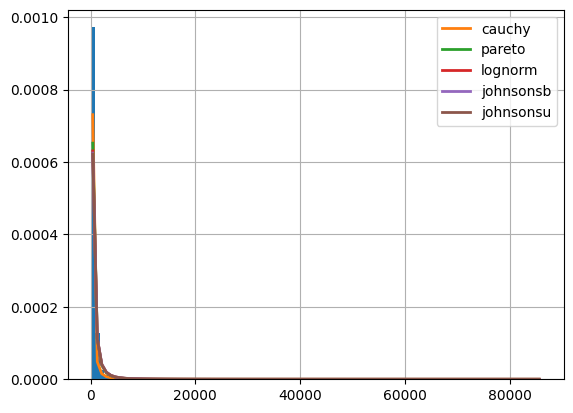

In [11]:
f = fitter.Fitter(df_times['arrival_diff'], distributions= flexsim_distributions)
f.fit()
f.summary()

best = f.get_best(method='sumsquare_error') 

In [12]:
for key, val in best.items():
    dist = key
    params = [key]
    
    for key2, val2 in val.items():
        params.append(round(float(val2),4))
        print(round(val2,4), type(val))
        
params

215.3303 <class 'dict'>
181.5146 <class 'dict'>


['cauchy', 215.3303, 181.5146]

In [13]:
# Resample to daily data by averaging the time differences
#df_daily_diff = df_times['arrival_diff'].resample('D').mean()
#
#model = ExponentialSmoothing(df_daily_diff, trend=None, seasonal='add', seasonal_periods=7, freq='D').fit()
#forecast = model.forecast(30)
#
#fig, ax = plt.subplots(figsize = (20,5))
#
#df_daily_diff.plot(ax=ax)
#
#forecast.plot(ax=ax)

In [14]:
## Forecasting order rate
#
## Resample to daily data by averaging the time differences
#df_daily_diff = df_times['arrival_diff'].resample('D').mean()
#
## Getting start date for forecasting and date range
#start_date = df_daily_diff.index[-1] + pd.Timedelta(days=1)
#forecast_dates = pd.date_range(start=start_date, end='2026-12-31', freq='MS')
#
## Initialize forecast dataframe
#forecast_df = pd.DataFrame({'fecha_llegada':df_daily_diff.index, 'freq': df_daily_diff.values})
#
## Iterate through first day of each month
#for i, start_idx in enumerate(forecast_dates):
#    
#    forecast_horizon_days = len(pd.date_range(start=start_idx, end=start_idx + MonthEnd(0), freq='D'))# - 1
#    
#    model = ExponentialSmoothing(df_daily_diff, trend=None, seasonal='add', freq='D').fit()
#    forecast = model.forecast(forecast_horizon_days)
#    
#    # Create a DataFrame for this month's forecast
#    fc_temp_df = pd.DataFrame({'fecha_llegada':pd.date_range(start=start_idx, periods=forecast_horizon_days, freq='D'), 'freq':forecast.values / df_dv.values[i]})
#        
#    
#    forecast_df = pd.concat([forecast_df, fc_temp_df])
#    
#    # Update `df_daily_diff` with the new forecasted values
#    new_forecast_data = pd.Series(forecast.values, index=pd.date_range(start=start_idx, periods=forecast_horizon_days, freq='D'))
#    df_daily_diff = pd.concat([df_daily_diff, new_forecast_data])
#
#forecast_df = forecast_df.set_index('fecha_llegada')
#
## Separating dfs
#hist_df = forecast_df[forecast_df.index < pd.to_datetime('2023-06-01')]
#fc_df = forecast_df[(forecast_df.index >= pd.to_datetime('2023-06-01'))]
##fc_df = forecast_df[(forecast_df.index >= pd.to_datetime('2023-06-01')) & (forecast_df.index <= pd.to_datetime('2023-07-01'))]
#
#fig, ax = plt.subplots(figsize = (20,5))
#
#hist_df.plot(ax=ax)
#fc_df.plot(ax=ax, linestyle='--')

In [15]:
# Separate peaks and regular time difference
#
#seven_day_dates = pd.date_range(start='2023-03-05', end=forecast_df.index[-1], freq=f'7D')
#
#df_peaks = forecast_df[forecast_df.index.isin(seven_day_dates)]
#df_regular = forecast_df[~forecast_df.index.isin(seven_day_dates)]
#
#fig, ax = plt.subplots(figsize = (20,5))
#
#df_peaks.plot(ax=ax)
#df_regular.plot(ax=ax)
#
#df_peaks.to_csv('./data/sd_competencia/sd_competencia_pronostico_ordenes_peaks.csv')
#df_regular.to_csv('./data/sd_competencia/sd_competencia_pronostico_ordenes_regular.csv')

In [16]:
# Getting start date for forecasting and date range
#series_order_months = pd.date_range(start='2023-03-01', end='2026-12-31', freq='MS')
#
#dict_best_dists = {}
#
#for i, month in enumerate(series_order_months.month.values):
#    f = fitter.Fitter(df_peaks[df_peaks.index.month == month].dropna(), distributions= flexsim_distributions)
#    f.fit()
#    f.summary()
#    
#    # Get the best distribution and its parameters
#    best = f.get_best(method='sumsquare_error')
#    
#    # Extract the name of the distribution and its parameter values
#    dist_name = list(best.keys())[0]
#    parameter_values = list(best.values())[0].values()
#    
#    # Combine the distribution name and its parameters into a single list
#    dict_best_dists[series_order_months[i]] = [dict_flexsim_distributions[dist_name]] + list(parameter_values)
#
#df_dsts_peaks = pd.DataFrame.from_dict(dict_best_dists, orient='index')
#df_dsts_peaks.to_csv('./data/sd_competencia/sd_competencia_dists_ordenes_peaks.csv')
#

In [17]:
# Getting start date for forecasting and date range
#series_order_months = pd.date_range(start='2023-03-01', end='2026-12-31', freq='MS')
#
#dict_best_dists = {}
#
#for i, month in enumerate(series_order_months.month.values):
#    f = fitter.Fitter(df_regular[df_regular.index.month == month].dropna(), distributions= flexsim_distributions)
#    f.fit()
#    f.summary()
#    
#    # Get the best distribution and its parameters
#    best = f.get_best(method='sumsquare_error')
#    
#    # Extract the name of the distribution and its parameter values
#    dist_name = list(best.keys())[0]
#    parameter_values = list(best.values())[0].values()
#    
#    # Combine the distribution name and its parameters into a single list
#    dict_best_dists[series_order_months[i]] = [dict_flexsim_distributions[dist_name]] + list(parameter_values)
#
#df_dsts_regular = pd.DataFrame.from_dict(dict_best_dists, orient='index')
#df_dsts_regular.to_csv('./data/sd_competencia/sd_competencia_dists_ordenes_regular.csv')

In [18]:
# Get nombre_product forecasts df

df_forecast_nom_prod = pd.read_csv('./data/sd_competencia/sd_competencia_pronostico_demanda_pivot.csv').set_index('fecha_llegada')
df_forecast_nom_prod.index = pd.to_datetime(df_forecast_nom_prod.index)
df_forecast_nom_prod.head()

,Camiseta,Camisa Manga Larga,Camisa Manga Corta,Pantalón Corto,Pantalón,Sudadera,Polos,Chinos,Trajes,Camisas,...,Maletines,Pañuelos,Abrigos,Chaquetas,Sueteres,Chalecos,Sacos,Sueteres de Cuello Alto,Gabardinas,Bermudas
fecha_llegada,,,,,,,,,,,,,,,,,,,,,
2023-03-01,5177.0,3577.0,3763.0,805.0,615.0,224.0,380.0,230.0,25788.0,59294.0,...,410.0,591.0,11197.0,11189.0,2991.0,4133.0,3525.0,3282.0,6548.0,9227.0
2023-03-02,5342.0,3803.0,3827.0,888.0,669.0,245.0,361.0,236.0,28476.0,65424.0,...,392.0,601.0,12512.0,12858.0,3237.0,6571.0,4381.0,3344.0,6854.0,10836.0
2023-03-03,4648.0,3420.0,3348.0,784.0,602.0,200.0,289.0,208.0,30799.0,71616.0,...,386.0,529.0,14618.0,14349.0,3667.0,4780.0,3914.0,3357.0,7751.0,11980.0
2023-03-04,5859.0,4052.0,4093.0,969.0,753.0,252.0,373.0,248.0,30266.0,71067.0,...,478.0,773.0,14434.0,14425.0,3654.0,11327.0,7672.0,3529.0,7837.0,11111.0
2023-03-05,854.0,533.0,591.0,133.0,109.0,34.0,45.0,39.0,6874.0,14210.0,...,61.0,117.0,3306.0,3045.0,895.0,843.0,827.0,816.0,1635.0,2368.0


<Axes: xlabel='fecha_llegada'>

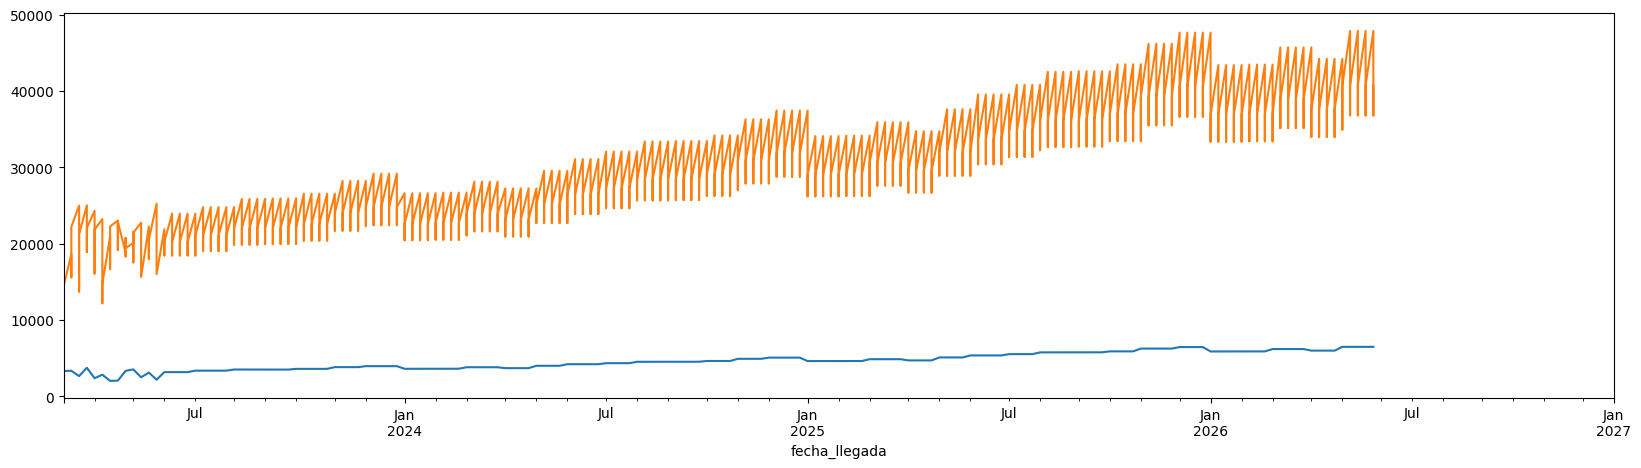

In [19]:
# Separate peaks and regular demand nombre_producto

seven_day_dates = pd.date_range(start='2023-03-05', end='2026-12-31', freq=f'7D')

df_nom_prod_peaks = df_forecast_nom_prod[df_forecast_nom_prod.index.isin(seven_day_dates)]
df_nom_prod_regular = df_forecast_nom_prod[~df_forecast_nom_prod.index.isin(seven_day_dates)]

fig, ax = plt.subplots(figsize = (20,5))

df_nom_prod_peaks['Abrigos'].plot(ax=ax)
df_nom_prod_regular['Abrigos'].plot(ax=ax)


In [20]:
# Get distributions for each nombre_producto and month regular

# Getting start date for forecasting and date range
series_order_months = pd.date_range(start='2023-03-01', end='2026-12-31', freq='MS')

# Initialize the dictionary to store results
dict_best_dists_nombre_prod = {}

# Iterate through each nombre_producto (column in the DataFrame)
for nom_prod in df_nom_prod_regular.columns:
    
    dict_best_dists_nombre_prod[nom_prod] = {}  # Create a nested dictionary for each nombre_producto
    
    for i, month in enumerate(series_order_months.values):
        # Filter data for the current nombre_producto and month
        data = df_nom_prod_regular[nom_prod][(df_nom_prod_regular.index >= month) & (df_nom_prod_regular.index < month + MonthEnd(0))].dropna()
        
        if not data.empty:  # Ensure there's data to fit
            f = fitter.Fitter(data, distributions=flexsim_distributions)
            f.fit()
            
            # Get the best distribution and its parameters
            best = f.get_best(method='sumsquare_error')
            
            # Extract the name of the distribution and its parameter values
            dist = ''
            params = []
            for key, val in best.items():
                dist = key
                shapes = []
                loc_scale = []
                for key2, val2 in val.items():

                    if key2 in ['loc', 'scale']:
                        loc_scale.append(round(float(val2),4))
                    else:
                        shapes.append(round(float(val2),4))
                    
                    params = [dist, *loc_scale, *shapes]
            
            # Format the result as "return [function(arg1, arg2, ...);]"
            formatted_result = f'return {dict_flexsim_distributions[params[0]]}({", ".join(f"{x}" for x in params[1:])});'
            # Store the formatted result
            dict_best_dists_nombre_prod[nom_prod][series_order_months[i]] = formatted_result
        else:
            # If there's no data for the month, store None
            dict_best_dists_nombre_prod[nom_prod][series_order_months[i]] = None

# Convert the nested dictionary into a DataFrame
df_dsts_regular = pd.DataFrame.from_dict({k: pd.Series(v) for k, v in dict_best_dists_nombre_prod.items()})

# Save the DataFrame to a CSV file
df_dsts_regular.to_csv('./data/sd_competencia/sd_competencia_dists_nom_prod_regular.csv', encoding='utf-8-sig')


KeyboardInterrupt: 

In [21]:
# Get distributions for each nombre_producto and month regular

# Getting start date for forecasting and date range
series_order_months = pd.date_range(start='2023-03-01', end='2026-12-31', freq='MS')

# Initialize the dictionary to store results
dict_best_dists_nombre_prod = {}

# Iterate through each nombre_producto (column in the DataFrame)
for nom_prod in df_nom_prod_peaks.columns:
    
    dict_best_dists_nombre_prod[nom_prod] = {}  # Create a nested dictionary for each nombre_producto
    
    for i, month in enumerate(series_order_months.values):
        # Filter data for the current nombre_producto and month
        data_regular = df_nom_prod_regular[nom_prod][(df_nom_prod_regular.index >= month) & (df_nom_prod_regular.index < month + MonthEnd(0))].dropna().mean()
        data = df_nom_prod_peaks[nom_prod][(df_nom_prod_peaks.index >= month) & (df_nom_prod_peaks.index < month + MonthEnd(0))].dropna().mean()
        
        if not pd.isna(data) and not pd.isna(data_regular) and data_regular != 0:
            dict_best_dists_nombre_prod[nom_prod][series_order_months[i]] = round(data/data_regular,4)
        else:
            # If there's no data for the month, store None
            dict_best_dists_nombre_prod[nom_prod][series_order_months[i]] = 0

# Convert the nested dictionary into a DataFrame
df_dsts_peaks = pd.DataFrame.from_dict({k: pd.Series(v) for k, v in dict_best_dists_nombre_prod.items()})

# Save the DataFrame to a CSV file
df_dsts_peaks.to_csv('./data/sd_competencia/sd_competencia_dists_nom_prod_peaks.csv', encoding='utf-8-sig')


tiempo_descarga_camiones_s {'beta': {'a': np.float64(1.0216753550600743), 'b': np.float64(0.9731992006143662), 'loc': np.float64(594.4138744852976), 'scale': np.float64(725.5861255147025)}}
tiempo_estadia_camiones_s {'fisk': {'c': np.float64(8.012397335878227), 'loc': np.float64(-1937.3460998438754), 'scale': np.float64(3491.3654350144598)}}
tiempo_descarga_recibo_s {'uniform': {'loc': 30.0, 'scale': 40.0}}
tiempo_revision_cajas_s {'beta': {'a': np.float64(0.9066864488238495), 'b': np.float64(0.9113278304841889), 'loc': np.float64(19.999999999999996), 'scale': np.float64(30.01421247670255)}}
tiempo_revision_perchas_s {'uniform': {'loc': 20.0, 'scale': 50.0}}
tiempo_traslado_a_devoluciones_s {'beta': {'a': np.float64(1.0244444256011347), 'b': np.float64(0.8868841590378533), 'loc': np.float64(9.92849463326581), 'scale': np.float64(30.071505366734193)}}
tiempo_reintegro_cajas_s {'beta': {'a': np.float64(1.0192489243732377), 'b': np.float64(0.9596235300701342), 'loc': np.float64(14.9941696

{'beta': {'a': np.float64(0.9066864488238495),
  'b': np.float64(0.9113278304841889),
  'loc': np.float64(19.999999999999996),
  'scale': np.float64(30.01421247670255)}}

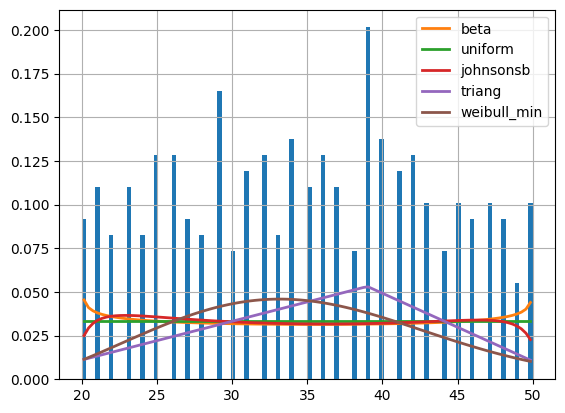

In [8]:
df_tiempos = pd.read_csv('./data/sd_competencia/sd_competencia_tiempos.csv')

for i, col in enumerate(df_tiempos):
    data = pd.to_numeric(df_tiempos[col]).dropna()
    f = fitter.Fitter(data, distributions=flexsim_distributions)
    f.fit()
            
    # Get the best distribution and its parameters
    print(col, f.get_best(method='sumsquare_error'))
    
data = pd.to_numeric(df_tiempos['tiempo_revision_cajas_s']).dropna()
f = fitter.Fitter(data, distributions=flexsim_distributions)
f.fit()
f.summary()

f.get_best(method='sumsquare_error')